# Tema 3: Osnovne statistične analize
## Analiza prometnih nesreč
Knjižnica `pandas` omogoča številne možnosti za analizo in vizualizacijo podatkov. Podatki za statistične analize so velikokrat dostopni v obliki besedilnih datatotek (.txt ali .csv) ali Excel formatu (.xlsx). Knjižnica omogoča preprosto nalaganje podatkov, filtriranje, čiščenje podatkov in statistično analizo, tudi z uporabo `scipy.stat` knjižnice, ter vizualno analizo podatkov z uporabo `matplotlib` knjižnice.

V nadaljevanju bomo:
- s spleta pridobili podatke o prometnih nesrečah
- naložili podatke iz več vhodnih datotek in jih združili in prečistili za potrebe analize
- izvedli osnovne statistične analize (opisne statistike, hi-hvadrat test neodvisnosti vzorcev)
- prikazali podatke v grafih

Pri tem bomo potrebovali in spoznali:
- knjižnico `io` za dostop do datotek
- postopek izdelave lastnih funkcij
- postopke čiščenja in prilagajanja podatkov s knjižnico `pandas`
- statistične funkcije knjižnice `pandas` in `scipy.stat`
- prikaz grafov s funkcijami knjižnice `pandas` in `matplotlib`

### Pridobivanje podatkov

Za potrebe analize podatkov o prometnih nesrečah bomo podatke pridobili iz spleta, in sicer iz spletne strani Agencije za varnost v prometu RS. Izbrali smo enajstletno obdobje od 1.1.2010 do 31.12.2020 in se osredotočili na občino Maribor. V navedem obdobju je bilo zabeleženih skoraj 6000 prometnih nesreč. 

Prva težava nastopi že pri samem pridobivanju podatkov, saj portal AVP omogoča hkraten izvoz do največ 1000 zapisov. Zato moramo podatke izvoziti po letih. Na ta način dobimo 11 datotek v formatu MS Excel.

Povezava do podatkov na AVP: http://nesrece.avp-rs.si/?zoom=2&lat=176250.11991&lon=532424.57558&layers=B00FFFFFFFFT&DatumOd=01.01.2010&DatumDo=31.12.2020&Regija=2&Obcina=70&Klasifikacija=L%2CH%2CS 

Za lažje nadaljnje delo je paket vseh 11 datotek na voljo v GitHub repozitoriju https://github.com/NenadCB/promet v obliki ZIP datoteke nesrece.zip. 

Da bo dostop do podatkov iz Jupyter beležnice (.ipynb) kar najbolj preprost, si lahko ustvarimo mapo 'nesreče' v mapi, kjer sicer shranjujemo Jupyter beležnice. V to mapo pa razpakiramo ZIP datoteko.

In [2]:
import os
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

pd.set_option("display.precision", 2)

### Uvoz podatkov

Vse podatke, ki smo jih pridobili, želimo naložiti v eno tabelo, oziroma en `DataFrame`. Seveda pa podatke nalagamo iz vsake datoteke posebej. Podatke ene datoteke naložimo `DataFrame`, nato pa naloženo priključimo v skupni `DataFrame`. 

Imena datotek, ki jih bomo naložili, bi lahko zapisali v seznam in nato v zanki naložili datoteke eno za drugo. Vendar bi v primeru velikega števila vhodnih datotek ustvarjanje takšnega seznama zahtevalo veliko časa ter predstavljalo velik vir možnih napak.

Zato bomo imena datotek pridobili kar iz operacijskega sistema. Vse datoteke so shranjene v mapi.
Do map in datotek na disku pa lahko dostopamo s pomočjo funkcij knjižnice `os`. V nadaljevanju je vzorec, ki ga lahko uporabimo, če želimo pregledati vse datoteke v izbrani mapi.

V prvem primeru bomo izpisali imena vseh datotek v mapi 'nesreče', ki se nahaja v mapi, kjer je shranjen tudi naš program. Ker bi v mapi lahko bile še druge datoteke, izmed vseh najdenih datotek izpišimo samo imena datotek s končnico '.xslx'. 

Uporabimo:
- `scandir(ime_mape)`: funkcija vrne vsebino izbrane mape
- `is_file()`: funkcija vrne True, če je objekt datoteka, če ne (npr. če je mapa) pa vrne False
- `path.splitext(ime_datoteke)`: funkcija razcepi ime datoteke na ime in na končnico

Več o funkcijah za pridobivanje informacij o datotekah in mapah: https://docs.python.org/3/library/os.path.html

In [4]:
mapa = 'nesreče'
vsebina_mape = os.scandir(mapa)

print(f'Vsebina mape: {mapa}')
print('*'*25)
for el in vsebina_mape:
    if el.is_file():
        ime, koncnica = os.path.splitext(el.name)
        if koncnica == '.xlsx':
            print(f'datoteka: {ime}')


Vsebina mape: nesreče
*************************
datoteka: view_bpn_n_10
datoteka: view_bpn_n_11
datoteka: view_bpn_n_12
datoteka: view_bpn_n_13
datoteka: view_bpn_n_14
datoteka: view_bpn_n_15
datoteka: view_bpn_n_16
datoteka: view_bpn_n_17
datoteka: view_bpn_n_18
datoteka: view_bpn_n_19
datoteka: view_bpn_n_20


V našem primeru so podatki o nesrečah shranjeni po letih, in sicer so v eni datoteki zapisani podatki za eno leto. To je rezultat izvoza iz spletne strani, ki omogoča, da v eno datoteko izvozimo le 1000 vrstic. Če želimo analizirati podatke iz več let, jih bo za en izvoz praviloma preveč. Za analizo želimo podatke združiti. Zato bomo podatke iz vseh datotek naložili v en ```DataFrame```. Za nalaganje podatkov bomo uporabili pravkar pridobljena imena datotek. 
porabimo:
- `read_excel(naslov_datoteke)`: funkcija uvozi podatke iz datoteke v `pandas.DataFrame`
- `concat(seznam_df)`: funkcija združi podatke iz DataFrame-ov, ki jih naštejemo v seznamu

Več o funkciji za branje Excel datotek: https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html

Po potrebi lahko z dodatnimi parametri pri klicu funkcije nastavljamo različne načine interpretacije podatkov v datoteki, kot npr. decimalni separator, koliko vrstic želimo pri branju preskočiti...

In [78]:
vsebina_mape = os.scandir('nesreče')

df_nesrece = pd.DataFrame()
for el in vsebina_mape:
    if el.is_file():
        ime, koncnica = os.path.splitext(el.name)
        if koncnica == '.xlsx':
            #naložimo eno datoteko v svoj DataFrame
            eno_leto = pd.read_excel(f'nesreče/{el.name}')
            #združimo pravkar naložene podatke z že naloženimi v df_nesrece
            df_nesrece = pd.concat([df_nesrece, eno_leto])


Rezultat združevanja je `DataFrame` z imenom df_nesrece, ki vsebuje podatke iz vseh datotek v mapi _nesreče_. 

### Pregled strukture in vsebine podatkov

Prvi vtis o __strukturi podatkov__ dobimo s pregledom nabora stolpcev tabele.

In [10]:
df_nesrece.columns

Index(['FID', 'key', 'regijao', 'obcinao', 'datum', 'mesec', 'dan', 'dannoc',
       'ura_int1', 'vreme', 'povrsje', 'vozisce', 'promet', 'klas', 'priority',
       'tip', 'vzrok', 'dc', 'lovc', 'nas', 'kraj', 'pcestao', 'cesta',
       'podseko', 'odsek', 'stac', 'osebe', 'st_oseb', 'ishs', 'the_geom'],
      dtype='object')

Prvi vtis o __vsebini podatkov__ dobimo z izpisom nekaj vrstic iz tabele. Če zahtevamo prikaz celega ```DataFrame```, se bo izpisalo prvih 10 in zadnjih 10 vrstic. S funkcijama ```head()``` in ```tail()``` lahko prikažemo poljubno število vrstic v začetku ali na koncu tabele.

In [12]:
df_nesrece.head(5)

,FID,key,regijao,obcinao,datum,mesec,dan,dannoc,ura_int1,vreme,...,kraj,pcestao,cesta,podseko,odsek,stac,osebe,st_oseb,ishs,the_geom
0,view_bpn_n.fid-5ebb29ff_1956bb4b5ee_6f86,100679170,PODRAVSKA,HOČE-SLIVNICA,2010-07-16,7,5,noč,02-03,O,...,C,ŠENTILJ-MB-K.DEKANI-KOPER,A1,MARIBOR PTUJSKA-SLIVNICA,66.0,200.0,"{D;OA;[25-34];P;0;0;0,N;TV;[25-34];N;0;0;0,N;P...",3,False,POINT (552579 152968)
1,view_bpn_n.fid-5ebb29ff_1956bb4b5ee_6f87,100688270,PODRAVSKA,MARIBOR,2010-11-05,11,5,noč,18-19,J,...,C,MARIBOR,33,KREKOVA ULICA,NaN,NaN,"{D;MK;[55-64];N;0;0;0,N;PE;[55-64];0;0;0;0}",2,True,POINT (549716 157726)
2,view_bpn_n.fid-5ebb29ff_1956bb4b5ee_6f88,100684435,PODRAVSKA,MARIBOR,2010-09-18,9,6,noč,04-05,D,...,C,MARIBOR,33,KRALJEVIČA MARKA ULICA,NaN,NaN,"{D;PE;[25-34];0;0;0;0,N;AV;[45-54];N;N;0;N}",2,True,POINT (551259 157454)
3,view_bpn_n.fid-5ebb29ff_1956bb4b5ee_6f89,100684988,PODRAVSKA,MARIBOR,2010-09-22,9,3,dan,16-17,J,...,C,MARIBOR,33,ULICA MOŠE PIJADA,NaN,NaN,{D;MK;[45-54];0;0;0;0},1,True,POINT (549693 156822)
4,view_bpn_n.fid-5ebb29ff_1956bb4b5ee_6f8a,100673389,PODRAVSKA,MARIBOR,2010-05-04,5,2,dan,06-07,O,...,C,MB(KOR.MOST)-RUŠE-SELNICA,435,MARIBOR-RUŠE,1431.0,2400.0,"{D;OA;[45-54];0;0;0;0,N;TV;[35-44];N;0;0;0}",2,False,POINT (545962 157196)


V tabeli vidimo, da so določeni stolpci za naše analize brez pravega pomena, kot npr. FID ali key ali pa regijao, ki vsebuje enako vrednost v vseh vrsticah, saj smo tako izbirali podatke. Takšne stolpce bomo pred izvedbo analiz običajno izbrisali iz tabele (glej spodaj). 

Ko smo dobili vtis o vsebini, je smiselno prevertiti kakšne __podatkovne tipe__ je funkcija nalaganja podatkov prepoznala po posameznih stolpcih. Vrsta podatkov, tako po naravi same merjene količine kot tudi glede na podatkovni tip, namreč pomembno vpliva na to, kakšne analize so nam na razpolago.

In [45]:
df_nesrece.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5931 entries, 0 to 319
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   FID       5931 non-null   object        
 1   key       5931 non-null   int64         
 2   regijao   5931 non-null   object        
 3   obcinao   5931 non-null   object        
 4   datum     5931 non-null   datetime64[ns]
 5   mesec     5931 non-null   int64         
 6   dan       5931 non-null   int64         
 7   dannoc    4172 non-null   object        
 8   ura_int1  5931 non-null   object        
 9   vreme     5931 non-null   object        
 10  povrsje   5931 non-null   object        
 11  vozisce   5931 non-null   object        
 12  promet    5931 non-null   object        
 13  klas      5931 non-null   object        
 14  priority  5931 non-null   int64         
 15  tip       5931 non-null   object        
 16  vzrok     5931 non-null   object        
 17  dc        4172 non-n

<br>V izpisu vidimo, da je precej stolpcev opredeljenih kot splošen tip ```object```, po večini bodo ti podatki obravnavani kot znakovni niz. Vidimo tudi, da sta podatka __odsek__ in __stac__ prepoznana kot števila z decimalno vejico, kar je vsebinska napaka in nam lahko povzroča težave pri iskanju in filtriranju podatkov. Prav tako vidimo, da je v nekaterih stolpcih število zapisov brez podatka (non-null) manjše od skupnega števila vrstic v tabeli, kar lahko vpliva na analize teh stolpcev zaradi manjkajočih podatkov.

Podrobneje lahko preverimo še nabore vrednosti po posameznih stolpcih.

Uporabimo:
- `nunique`: funkcija izpiše število unikatnih podatkov v stolpcu
- `value_counts`: funkcija izpiše kolikokrat se določena vrednost v stolpcu ponovi

In [96]:
print(f'v stolpcu "vzrok" se nahaja {df_nesrece["vzrok"].nunique()} različnih vrednosti')
print()
print('število pojavitev posamične vrednosti v tabeli:')
print(df_nesrece['vzrok'].value_counts())

v stolpcu "vzrok" se nahaja 11 različnih vrednosti

število pojavitev posamične vrednosti v tabeli:
vzrok
PD    1796
VR    1287
OS     697
HI     693
PV     669
SV     627
NP      73
PR      60
VO      16
CE      11
TO       2
Name: count, dtype: int64


Takšne stolpce je smiselno pretvoriti v podatkovni tip ```Categorical```, saj zasede bistveno manj prostora in ker je podatkovni tip konkretneje določen, funkcije nad takšnimi stolpci delujejo hitreje. Podatke v celem stolpcu zato prepišemo z novimi vrednostmi, ki sicer ohranijo vsebino, vendar so sedaj drugega podatkovnega tipa.

In [51]:
df_nesrece['vzrok'] = pd.Categorical(df_nesrece['vzrok'])

preverimo tip podatkov v stolpcu

In [53]:
df_nesrece['vzrok'].dtype

CategoricalDtype(categories=['CE', 'HI', 'NP', 'OS', 'PD', 'PR', 'PV', 'SV', 'TO', 'VO',
                  'VR'],
, ordered=False, categories_dtype=object)

V kategorije pretvorimo še preostale stolpce, ki vsebujejo takšne podatke. 

Najprej poglejmo, kdo so kandidati:

In [55]:
df_nesrece.nunique()

FID         5931
key         5931
regijao        1
obcinao        5
datum       2924
mesec         12
dan            7
dannoc         2
ura_int1      24
vreme          6
povrsje        9
vozisce        5
promet         5
klas           3
priority       3
tip           10
vzrok         11
dc             2
lovc           9
nas            2
kraj          16
pcestao       62
cesta         75
podseko      444
odsek        279
stac         334
osebe       2841
st_oseb       12
ishs           2
the_geom    2648
dtype: int64

In [10]:
stolpci = ['dannoc', 'vreme', 'povrsje', 'vozisce', 'promet', 'klas', 'priority',
       'tip', 'vzrok', 'dc', 'lovc', 'nas']

for s in stolpci:
    df_nesrece[s] = pd.Categorical(df_nesrece[s])
    

Nekaj več dela bomo imeli s pretvorbo podatkov o odsekih. Pri nalaganju podatkov so bili ti podatki prepoznani kot števila z decimalno vejico. Podatke lahko sicer preprosto pretvorimo v podatkovni tip `string`, vendar težava nastopi, ker so se že pri nalaganju podatkov pri pretvorbi izgubile vodeče ničle pri zapisu številke odseka, pri pretvorbi v znakovni niz pa se ohrani tudi decimalna pika in decimalke.

In [138]:
df_nesrece['odsek'] = df_nesrece['odsek'].astype(str)

In [16]:
df_nesrece['odsek'].head(5)

0      66.0
1       nan
2       nan
3       nan
4    1431.0
Name: odsek, dtype: object

Podatke lahko popravimo tako, da za vsako vrstico preberemo obstoječ podatek ter ga uporabimo za izračun nove vrednosti, s katero bomo prepisali obstoječo vrednost.

Preslikavo lahko naredimo tako, da v zanki obdelamo vse vrstice tabele. Vendar ima `DataFrame` za primer, ko želimo obdelati vse vrstice, na voljo funkcijo `apply()`. Tej funkciji lahko posredujemo predpis v obliki funkcije, ki jo sami izdelamo, in naj se uporabi za vse vrstice v tabeli. Funkcija `apply()` bo samodejno aplicirala našo poljubno funkcijo tako, da bo našo funkcijo poklicala in ji kot vhodni podatek posredovala vrednost iz tekoče vrstice. 

Preslikavo iz stare v novo vrednost številke odseka bomo tako definirali kot funkcijo, ki sprejme en parameter (staro vrednost). V funkciji bomo izračunali novo vrednost in jo vrnili kot rezultat. 

#### definicija lastne funkcije

Najprej si poglejmo, kako v Pythonu sploh definiramo funkcijo. 

Kot je razvidno iz primera spodaj, določimo poljubno ime funkcije in v oklepajih navedemo poljubno število vhodnih parametrov. Preko vhodnih parametrov funkciji ob klicu posredujemo dejanske vrednosti.

Parametri so spremenljivke s katerimi izračunamo želeno vrednost. 

Rezultat funkcije vrnemo z ukazom `return`.

In [110]:
def moja_funkcija(a, b, c):
    d = a + b
    d = d * c
    return d

#lastno funkcijo pokličemo kot katerokoli drugo funkcijo
x, y, z = 3, 5, 2
rezultat = moja_funkcija(x, y, z)

rezultat

16

Na podoben način ustvarimo funkcijo `pretvori_odsek()`, s katero bomo obstoječe podatke o odsekih pravilno oblikovali.

Iz tabele s podatki je razvidno, da lahko ločimo med vrsticami, kjer podatka o odseku ni, ter med vrsticami, kjer podatek o odseku obstaja. Če podatka ni, naj funkcija vrne vrednost `NaN`. To je  vrednost, ki označuje, da podatek manjka. Vrednost `NaN` lahko ustvarimo na več načinov, eden izmed teh je, da pokličemo funkcijo `float()`, ki ji posredujemo znakovni niz 'nan' - torej `float('nan')`.

V primerih, ko podatek obstaja, je iz primerov razvidno, da se zmeraj konča s piko on ničlo (npr. '66.0'). Zadnja dva znaka sta odveč in ju bomo iz niza odstranili. Hkrati je potrebno zagotoviti, da če je številka odseka krajša od štirih znakov, da jo na levi strani dopolnimo z vodečimi ničlami.  

Spodaj sta dve možnosti, kako bi lahko zapisali funkcijo. Prvi primer prikazuje dopolnjevanje z vodečimi ničlami z uporabo rezanja besedilnih nizov, drugi primer pa isto nalogo opravi z uporabo f-stringa ter oblikovanja. Katerikoli pristop uberemo, je enako dobro.

>Spomnimo: Formate za oblikovanje f-stringov najdemo na https://fstring.help/cheat/ 

In [125]:
def pretvori_odsek(o):
    if o == 'nan':
        return float('nan')       # float('nan') vrne 'not a number', kar pomeni manjkajočo vrednost podatka
    else:                         #primer: 66.0 
        rez = '0000' + o[:-2]     # rez = '0000' + '66' = '000066' - uporabi vse razen zadnja dva znaka
        rez = rez[-4:]            # rez = '0066'  - uporabi samo zadnje štiri znake 
        return rez

def pretvori_odsek(o):
    if o == 'nan':
        return float('nan')       
    else:
    # uporabi številko brez zadnjih dveh znakov in jo dopolni z 0 iz leve strani do dolžine štiri
        return f'{o[:-2]:0>4}'  
        
pretvori_odsek('66.0')  #preizkusimo delovanje funkcije, preden jo uporabimo nad vsemi podatki

'0066'

Pravkar ustvarjeno funkcijo apliciramo na vse vrstice tabele nesreč. 

Funkcija `apply()` bo iz stolpca, ki ga uporabimo za klic funkcije (v našem primeru 'odsek'), prebrala vrednost ter jo posredovala v funkcijo `pretvori_odsek()`. Funkcija `pretvori_odsek()` vrne izračunano vrednost funkciji `apply()`, le-ta pa jo vrne kot rezultat, ki ga zapišemo nazaj v isti stolpec (kar v splošnem ni nujno, vendar starega "pokvarjenega" podatka o odsekih več ne potrebujemo). 

In [140]:
df_nesrece['odsek'] = df_nesrece['odsek'].apply(pretvori_odsek)

#preverimo rezulate
df_nesrece[['odsek', 'stac']]

,odsek,stac
0,0066,200.0
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,1431,2400.0
...,...,...
315,0236,1.0
316,0637,2.0
317,1605,0.0
318,0534,42.0


### Opisne statistike
Preverimo osnovne opisne statistike izbranih stolpcev. Parameter inlcude='all' vključi tudi stolpce, ki niso numerični.

S funkcijo `describe()` prikažemo opisne statistike za vse stolpce tabele. Lahko pa prikaz omejimo. Stolpce, za katere želimo prikazati opisne statistike, v tem primeru podamo kot seznam:

In [22]:
df_nesrece[['dannoc','dan','st_oseb']].describe(include='all')

,dannoc,dan,st_oseb
count,4172,5931.00,5931.00
unique,2,NaN,NaN
top,dan,NaN,NaN
freq,3238,NaN,NaN
mean,NaN,3.13,2.21
std,NaN,1.82,1.05
min,NaN,0.00,1.00
25%,NaN,2.00,2.00
50%,NaN,3.00,2.00
75%,NaN,5.00,3.00


DataFrame očistimo stolpcev, ki niso zanimivi za analize.

In [24]:
df_n = df_nesrece.drop(['FID', 'key', 'regijao'], axis=1)  # axis = 1 pomeni, da brišemo stolpec
df_n.head(3)

,obcinao,datum,mesec,dan,dannoc,ura_int1,vreme,povrsje,vozisce,promet,...,kraj,pcestao,cesta,podseko,odsek,stac,osebe,st_oseb,ishs,the_geom
0,HOČE-SLIVNICA,2010-07-16,7,5,noč,02-03,O,SU,AH,N,...,C,ŠENTILJ-MB-K.DEKANI-KOPER,A1,MARIBOR PTUJSKA-SLIVNICA,0066,200.0,"{D;OA;[25-34];P;0;0;0,N;TV;[25-34];N;0;0;0,N;P...",3,False,POINT (552579 152968)
1,MARIBOR,2010-11-05,11,5,noč,18-19,J,SU,AH,N,...,C,MARIBOR,33,KREKOVA ULICA,NaN,NaN,"{D;MK;[55-64];N;0;0;0,N;PE;[55-64];0;0;0;0}",2,True,POINT (549716 157726)
2,MARIBOR,2010-09-18,9,6,noč,04-05,D,MO,AH,R,...,C,MARIBOR,33,KRALJEVIČA MARKA ULICA,NaN,NaN,"{D;PE;[25-34];0;0;0;0,N;AV;[45-54];N;N;0;N}",2,True,POINT (551259 157454)


### filtriranje in povpraševanje

Ko so podatki prečiščeni in je tabela pripravljena, lahko izvajamo najrazličnejša povpraševanja po podatkih. 

Z navedbo imena stolpca ali seznama stolpcev lahko omejimo prikaz stolpcev tabele.

#### izbira stolpcev

In [163]:
df_n['cesta'].head(5)

0     A1
1     33
2     33
3     33
4    435
Name: cesta, dtype: object

In [165]:
df_n[['cesta', 'odsek']].head(5)

,cesta,odsek
0,A1,0066
1,33,NaN
2,33,NaN
3,33,NaN
4,435,1431


#### izbira vrstic

Za izbiro vrstic lahko uporabimo logične pogoje v katerih bodo upoštevane vrednosti posameznih stolpcev.

Stolpec lahko primerjamo z izbrano vrednostjo. Primerjava se izvede za vse vrstice in rezultat je nabor vrednosti True ali Flase, glede na to ali vrednost v vrstici ustreza zapisanemu pogoju.


In [52]:
df_n['cesta']=='A1'

0       True
1      False
2      False
3      False
4      False
       ...  
315    False
316    False
317    False
318    False
319    False
Name: cesta, Length: 5931, dtype: bool

Glede na izračunane vrednosti True ali False lahko filtriramo tabelo. Seznam True/False v oglatih oklepajih povzroči, da se prikažejo samo vrstice za katere navedemo vrednost True.

V praksi to pomeni, da če želimo prikazati vrstice glede na vrednost v enem ali več stolpcih, v oglate oklepaje zapišemo logični pogoj, ki preverja vrednosti iz izbranih stolpcev. Na primer, prikažimo samo vrstice, kjer je v stolpcu 'cesta' zapisana vrednost 'A1':  

In [48]:
df_n[df_n['cesta']=='A1']

,obcinao,datum,mesec,dan,dannoc,ura_int1,vreme,povrsje,vozisce,promet,...,kraj,pcestao,cesta,podseko,odsek,stac,osebe,st_oseb,ishs,the_geom
0,HOČE-SLIVNICA,2010-07-16,7,5,noč,02-03,O,SU,AH,N,...,C,ŠENTILJ-MB-K.DEKANI-KOPER,A1,MARIBOR PTUJSKA-SLIVNICA,0066,200.0,"{D;OA;[25-34];P;0;0;0,N;TV;[25-34];N;0;0;0,N;P...",3,False,POINT (552579 152968)
4,MARIBOR,2011-06-18,6,6,dan,05-06,J,SU,AH,N,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,DRAGUČOVA-MB PTUJSKA C.,0671,3550.0,"{D;TV;[18-24];N;P;0;0,N;TV;[35-44];N;0;0;0,N;P...",4,False,POINT (553381 156602)
96,PESNICA,2011-07-12,7,2,dan,10-11,J,SU,AH,N,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,DRAGUČOVA-MB PTUJSKA C.,0671,7100.0,"{D;OA;[35-44];0;P;0;0,N;TV;[55-64];N;0;0;0}",2,False,POINT (553410 153438)
185,MARIBOR,2011-09-23,9,5,dan,15-16,J,SU,AH,N,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,PESNICA DRAGUČOVA,0065,1000.0,"{D;TV;[45-54];N;0;0;0,N;OA;[25-34];N;0;0;0,N;P...",3,False,POINT (552392 161221)
360,MARIBOR,2011-04-14,4,4,dan,15-16,O,SU,AH,N,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,DRAGUČOVA-MB PTUJSKA C.,0071,5450.0,"{D;TV;[55-64];N;0;0;0,N;TV;[45-54];N;0;0;0,N;T...",3,False,POINT (554094 154758)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,MARIBOR,2019-10-26,10,6,NaN,00-01,J,SU,AH,N,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,DRAGUČOVA-MB PTUJSKA C.,0671,2500.0,"{D;OA;[25-34];P;0;P;N,N;PT;[25-34];0;0;0;0,N;O...",3,False,POINT (553036 157594)
357,HOČE-SLIVNICA,2019-12-17,12,2,NaN,07-08,J,SU,AH,N,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,PRIKLJ.MB CENTER-PTUJSKA,0162,55.0,"{D;OA;[18-24];N;0;0;0,N;PT;[35-44];0;0;0;0,N;T...",3,False,POINT (552609 153013)
24,MARIBOR,2020-09-01,9,2,NaN,20-21,J,SU,AH,N,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,PRIKLJ.MB VZHOD-ZRKOVSKA,0163,1062.0,"{D;PE;[55-64];0;0;N;N,N;OA;[35-44];N;0;0;0}",2,False,POINT (553940 155751)
47,MARIBOR,2020-10-27,10,2,NaN,07-08,O,SU,AZ,G,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,DRAGUČOVA-MB PTUJSKA C.,0671,2739.0,"{D;OA;[25-34];N;0;0;0,N;TV;[35-44];N;0;0;0,N;T...",3,False,POINT (553114 157368)


Pogoj lahko vključuje preverjanje več stolpcev. Pogoje med seboj povežemo z operatorjema IN (znak &) ter ALI (vertikalna črtica |)) Pozorni moramo biti na uporabo oklepajev, ker imata operaciji & (logični in) ter | (logični ali) prednost pred == (primerjanje):

In [158]:
df_n[(df_n['cesta']=='A1') & (df_n['odsek'] == '0066')]

,obcinao,datum,mesec,dan,dannoc,ura_int1,vreme,povrsje,vozisce,promet,...,kraj,pcestao,cesta,podseko,odsek,stac,osebe,st_oseb,ishs,the_geom
0,HOČE-SLIVNICA,2010-07-16,7,5,noč,02-03,O,SU,AH,N,...,C,ŠENTILJ-MB-K.DEKANI-KOPER,A1,MARIBOR PTUJSKA-SLIVNICA,0066,200.0,"{D;OA;[25-34];P;0;0;0,N;TV;[25-34];N;0;0;0,N;P...",3,False,POINT (552579 152968)
17,Hoče - Slivnica,2016-09-01,9,4,dan,12-13,J,SU,AH,N,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,MARIBOR PTUJSKA-SLIVNICA,0066,100.0,{D;TV;[35-44];N;0;0;0},1,False,POINT (552641 153001)
196,HOČE-SLIVNICA,2017-10-16,10,1,NaN,05-06,M,SU,AZ,N,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,MARIBOR PTUJSKA-SLIVNICA,0066,500.0,"{D;OA;[55-64];N;0;0;0,N;OA;[45-54];N;0;0;0}",2,False,POINT (552299 152795)


#### filtriranje vrstic in stolpcev hkrati - loc
Hkrati s filtriranjem vrstic lahko omejimo tudi nabor stolpcev, ki naj jih rezultat vključuje. 
Oba pogoja/filtra ponovno navedemo v oglatih oklepajih, tako da najprej napišemo filter vrstic glede na vrednosti stolpcev, nato pa podamo seznam stolpcev, ki jih želimo prikazati.

Če kombiniramo oba filtra, moramo pred oglate oklepaje zapisati `.loc`. S tem tabeli povemo, da bomo podatke iskali po vrednostih in nazivih stolpcev.  

In [58]:
df_n.loc[df_n['cesta']=='A1', ['mesec', 'dan']]

,mesec,dan
0,7,5
4,6,6
96,7,2
185,9,5
360,4,4
...,...,...
307,10,6
357,12,2
24,9,2
47,10,2


#### funkcija query()

Za iskanje ter filtriranje podatkov lahko uporabimo tudi zapis pogojev, kot jih navadno uporabljamo v SQL podatkovnih bazah. V ta namen uporabimo funkcijo `query()`.

>Pozor:
>- za zapis celotnega pogoja moramo uporabiti drugo vrsto narekovajev, \
kot jih uporabljamo za navedbo vrednosti stolpcev
>- za povezovanje pogojev v funkciji query uporabljamo 'and' in 'or' in ne znakov & ter |

In [46]:
df_n.query("cesta=='A1' and odsek=='0066'" )

,obcinao,datum,mesec,dan,dannoc,ura_int1,vreme,povrsje,vozisce,promet,...,kraj,pcestao,cesta,podseko,odsek,stac,osebe,st_oseb,ishs,the_geom
0,HOČE-SLIVNICA,2010-07-16,7,5,noč,02-03,O,SU,AH,N,...,C,ŠENTILJ-MB-K.DEKANI-KOPER,A1,MARIBOR PTUJSKA-SLIVNICA,0066,200.0,"{D;OA;[25-34];P;0;0;0,N;TV;[25-34];N;0;0;0,N;P...",3,False,POINT (552579 152968)
17,Hoče - Slivnica,2016-09-01,9,4,dan,12-13,J,SU,AH,N,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,MARIBOR PTUJSKA-SLIVNICA,0066,100.0,{D;TV;[35-44];N;0;0;0},1,False,POINT (552641 153001)
196,HOČE-SLIVNICA,2017-10-16,10,1,NaN,05-06,M,SU,AZ,N,...,C,ŠENTILJ-MB-CE-LJ-PO-SRMIN,A1,MARIBOR PTUJSKA-SLIVNICA,0066,500.0,"{D;OA;[55-64];N;0;0;0,N;OA;[45-54];N;0;0;0}",2,False,POINT (552299 152795)


### Analiza podatkov

Prečiščeni in filtrirani podatki praviloma služijo kot vhod v nadaljnje statistične analize, ki jih izvajamo s knjižnicami namenjenimi analizam, ali pa jih vizualiziramo v grafih. V nadaljevanju bomo demonstrirali preprosto analizo podatkov z uporabo knjižnice `scipy.stat`.

Podatki o nesrečah so v veliki meri izraženi s spremenljivkami, ki glede na tip merjenja sodijo med nominalne spremenljivke. Skladno s tem smo pri analizi podatkov dokaj omejeni. V nadaljevanju si bomo ogledali frekvence posameznih vrednosti ter preverili neodvisnost porazdelitev parov spremenljivk. 

Izdelali bomo:
- prikaz frekvenc vrednosti izbrane spremenljivke
- kontingenčno tabelo para spremenljivk
- hi-kvadrat test neodvisnosti spremenljivk
- grafični prikaz frekvenc v stolpičnem diagramu
- grafični prikaz kontingenc parov sremenljivk

Pri tem bomo uporabili:
- `value_counts`: funkcija vrne frekvence vrednosti izbrane spremenljivke
- `crosstab`: funkcija vrne frekvence kombinacij vrednosti dveh spremenljivk
- `chi2_contingency`: funkcija izvede test hi-kvadrat na osnovi kontingenčne tabele
- `matplotlib.pyplot`: pripravili bomo obliko grafov
- `pandas.DataFrame.plot`: uporabili bomo funkcionalnosti knjižnice pandas za prikaz grafov
  
Več o kontingenčnem $\chi^2$ statističnem testu lahko najdemo na spletu: https://pythonfordatascienceorg.wordpress.com/chi-square-python/ 


#### Frekvence
Prikažemo pogostost pojavnosti nesreče glede na stanje vozišča (blatno, mokro, suho...). Stanje vozišča je zapisano v spremenljivki __povrsje__. Zato bomo pogledali, kolikokrat se posamično stanje vozišča pojavi v tabeli nesreč.

Funkcija `value_counts` vrne objekt `Series`, to je enodimenzonalno polje podatkov. V polju so naštete frekvence vrednosti spremenljivke:

In [71]:
df_n['povrsje'].value_counts()

povrsje
SU    4535
MO    1155
OS      65
SP      62
SN      47
SL      32
PN      21
PP      13
BL       1
Name: count, dtype: int64

Objekt `Series` implementira številne funkcije za delo s podatki v polju. `Series` je podobna podatkovna struktura kot `DataFrame`, s tem da vsebuje samo en niz (en stolpec) podatkov. Med drugim omogoča tudi hiter izris grafov:

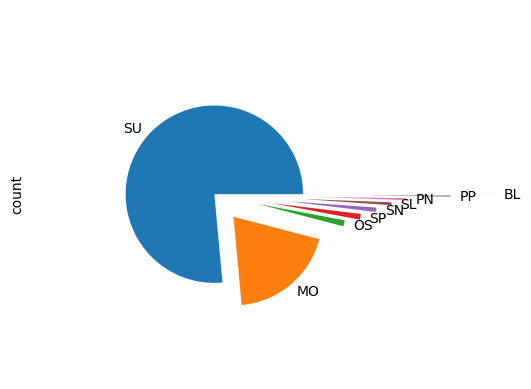

In [75]:
povrsje_frek = df_n['povrsje'].value_counts()

povrsje_frek.plot.pie(radius=0.6, explode=[0,.2,.3,.4,.5,.6,.7,1,1.3]);

#### Test neodvisnosti dveh spremenljivk  $\chi^2$

Zbrani podatki o nesrečah razvrščajo nesreče v različne kategorije po številnih dimenzijah, ki se nanašajo na okoliščine in na posledice nesreče. Kot smo videli pri pregledu spremenljivk, gre za nominalne spremenljivke. Če želimo preveriti ali obstaja statistično pomembna povezanost med nominalnimi spremenljivkami, za to lahko uporabimo kontingenčne tabele in test hi-kvadrat ($\chi^2$), če so za to izpolnjeni tudi dodatni pogoji. Dodaten pogoj je, da vse vrednosti pričakovanih frekvenc morajo biti večje kot 5. V primeru večjih kontingenčnih tabel pa se zadovoljimo s pogojem, da je vsaj 80% vrednosti večjih od 5, vse pa morajo biti večje od 1. Če pogoj ni izpolnjen, si lahko pomagamo tako, da nekatere kategorije smiselno med sabo združimo in test ponovimo (ali pa uporabimo ustrezen neparametrični test).

V nadaljevanju bomo:
- pripravili kontingenčno tabelo za dve spremenljivki
- izvedli test $\chi^2$
- preverili dodatne pogoje
- združili nekatere vrstice in stolpce kontingenčne tabele ter test ponovili

Najprej pripravimo kontingenčno tabelo, ki vsebuje frekvence hkratne pojavnosti posledic prometne nesreče (stolpec __klas__) ter pojavnosti gostote prometa (stolpec __promet__):

In [77]:
kon_tab = pd.crosstab(df_n['klas'], df_n['promet'])
kon_tab

promet,E,G,N,R,Z
klas,,,,,
H,10,25,204,71,0
L,158,883,3455,1079,2
S,0,5,26,13,0


Nato izvedemo statistični test. Za to uporabimo funkcijo `chi2_contingency`, ki jo najdemo v knjižnici `scipy.stat`.

In [79]:
res = chi2_contingency(kon_tab)
res

Chi2ContingencyResult(statistic=18.417542377560746, pvalue=0.018304940144070418, dof=8, expected_freq=array([[8.78098128e+00, 4.77204519e+01, 1.92606643e+02, 6.07873883e+01,
        1.04535491e-01],
       [1.57972686e+02, 8.58506323e+02, 3.46505564e+03, 1.09358472e+03,
        1.88062721e+00],
       [1.24633283e+00, 6.77322543e+00, 2.73377171e+01, 8.62788737e+00,
        1.48372956e-02]]))

Rezultat testa je n-terica, ki vključuje izračunano statistiko, p-vrednost, število prostostnih stopenj ter tabelo pričakovanih vrednosti frekvenc. N-terico lahko tudi razcepimo v posamične spremenljivke, nato pa preverimo še dodatne pogoje.

In [81]:
hi2, p, dof, ef = res
ef = ef.ravel()             # raztegnemo 2D tabelo v 1D seznam vseh vrednosti frekvenc
vec_od_pet = len(ef[ef>5])
manj_od_ena = len(ef[ef<1])

print(f'p={p:.4f}, pričakovane frekvence: skupaj={len(ef)}, >5={vec_od_pet}/{vec_od_pet/len(ef):.2f}, <1={manj_od_ena}')

p=0.0183, pričakovane frekvence: skupaj=15, >5=11/0.73, <1=2


Ker za uporabo testa hi-kvadrat niso izpolnjeni pogoji, bomo poskusili združiti pojavnost nesreče s smrtnim izzidom (S) in nesreče s hudimi poškodbami (H). Prav tako bomo združili promet z zastoji (Z) s stolpcem gost promet (G).

In [83]:
#seštejemo dve vrstici
kon_tab.loc['H'] += kon_tab.loc['S']
kon_tab = kon_tab.drop(['S'])          #brisanje vrstice

#seštejemo dva stolpca
kon_tab['G'] += kon_tab['Z']
kon_tab = kon_tab.drop('Z', axis=1)   #brisanje stolpca
kon_tab

promet,E,G,N,R
klas,,,,
H,10,30,230,84
L,158,885,3455,1079


Test ponovimo na novi kontingenčni tabeli.

In [85]:
res = chi2_contingency(kon_tab)

In [87]:
hi2, p, dof, ef = res
ef = ef.ravel()
vec_od_pet = len(ef[ef>5])
manj_od_ena = len(ef[ef<1])

print(f'p={p:.4f}, pričakovane frekvence: skupaj={len(ef)}, >5={vec_od_pet}/{vec_od_pet/len(ef):.2f}, <1={manj_od_ena}')

p=0.0014, pričakovane frekvence: skupaj=8, >5=8/1.00, <1=0


Rezultati testa hi-kvadrat pokažejo, da lahko zavržemo nulto hipotezo, da sta spremenljivki neodvisni. Torej lahko rečemo, da sta teža nesreče in gostota prometa povezani. 

#### Analiza podatkov v grafu

Za prikaze v grafih lahko uporabljamo funkcije, ki jih najdemo v knjižnici `pandas`. Knjižnica za izris grafov uporablja knjižnico `matplotlib`. Zato lahko z dodatno uporabo `matplotlib` pripravimo še nekoliko bolj bogate grafične prikaze.

Najprej ustvarimo graf, v katerem bomo prikazali razultate. Na primer, ustvarili bomo sliko z dvema grafoma. Nato bomo pripravili dve kontingenčni tabeli. Zapomniti si velja, da je tudi rezultat funkcije `crosstab` dejansko novi `DataFrame`. Zato lahko uporabljamo vse funkcije, ki jih tudi sicer uporabljamo z `DataFrame` in smo jih že spoznali, tudi funkcije za izris grafa in filtriranje stolpcev in vrstic.

Novost v prikazanem primeru je, da lahko funkcijam za izris grafa, kot parameter (parameter ax) podamo graf v katerem naj se izris pokaže. Če parametra ne podamo, pandas knjižnica sama ustvari novi graf. Če pa parameter podamo, bo DataFrame risal v podani obstoječi graf.

Ker smo obstoječi graf sami ustvarili, imamo sedaj dostop tudi do številnih funkcij za prilagajanje izgleda grafov. Določimo lahko naslov grafa, oznake osi ...


Text(0, 0.5, 'št. nesreč')

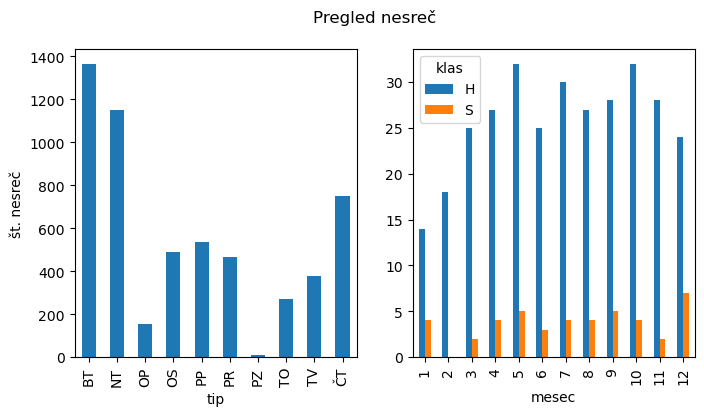

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

g_tip, g_mesec = ax

#izberemo prikaz lažjih prometnih nesreč - filter 'L'
pd.crosstab(df_n['tip'], df_n['klas'])['L'].plot.bar(ax = g_tip)

#izberemo prikaz hudih nesreč in nesreč s smrtnim izzidom - filter ['H', 'S']
pd.crosstab(df_n['mesec'], df_n['klas'])[['H','S']].plot.bar(ax = g_mesec)

fig.suptitle('Pregled nesreč')
g_tip.set_ylabel('št. nesreč')


### Primer

Za konec, z uporabo vsega do sedaj pridobljenega znanja, poskusimo s testom $\chi^2$ preveriti še, ali sta vpliv substanc pri povzročitelju nesreče ter teža posledic prometne nesreče med seboj neodvisna.

Na to vprašanje lahko odgovorimo, če poznamo stanje voznika in težo posledic. Slednji podatek smo že uporabljali in je shranjen v stolpcu __klas__. Kaj pa stanje voznika?

V tabeli obtaja stolpec __osebe__, v katerem so zakodirani podatki o udeleženih osebah. Med drugim je v tem stolpcu zapisano kakšno vozilo je vozil povročitelj nesreče ter ali je bil izveden alkotest in test na droge in ali je test pozitiven.

Težava je, da so vsi navedeni (in še več) podatki za vse udeležene osebe zakodirani v en sam znakovni niz (string). 

Spodnji primer prikazuje strukturo tega zapisa:

> {D;OA;[25-34];P;0;0;0,N;TV;[25-34];N;0;0;0,N;PT;[35-44];0;0;0;0}

- povzročitelj (da/ne)
- vrsta vozila
- starostna skupina (interval v letih)
- alkotest
- strokovni pregled alkoholoiziranosti
- hitri test na mamila
- strokovni pregled mamil

Podatki o osebah so zapisani v zavitih oklepajih, posamezne osebe so ločene z vejico, podatki o eni osebi pa so ločeni s podpičjem. To pravilo lahko uporabimo, da bi iz podatkov prepoznali, ali je povzročitelj nesreče vozil pod vplivom prepovedanih substanc. Recimo, da nas zanima, ali ima vsaj en povzročitelj, če je le-teh več, zapisano črko P (pozitivno) pri zadnjih štirih podatkih o osebi (alkohol ali mamila). 

In [199]:
df_n['osebe'].head(3)

0    {D;OA;[25-34];P;0;0;0,N;TV;[25-34];N;0;0;0,N;P...
1          {D;MK;[55-64];N;0;0;0,N;PE;[55-64];0;0;0;0}
2          {D;PE;[25-34];0;0;0;0,N;AV;[45-54];N;N;0;N}
Name: osebe, dtype: object

Pripravili bomo lastno funkcijo, ki iz podatkov izlušči povročitelje ter preveri njihovo stanje. Funkcija naj vrne P, če je povročitelj pozitiven na katerokoli substanco in N, če ni ugotovljeno preseganje predpisanih mejnih vrednosti. 

In [204]:
x = '{D;OA;[45-54];N;0;0;0,N;OA;[35-44];N;0;0;0,N;OA;[45-54];0;0;0;0,N;OA;[25-34];N;0;0;0}'
def alko(x):
    substance = 'N'
    osebe = x[1:-1].split(',')
    for os in osebe:
        oseba = os.split(';')
        if oseba[0] == 'D' and (oseba[3]=='P' or oseba[4]=='P' or oseba[5]=='P' or oseba[6]=='P'):
            substance = 'A'
            break;
    return substance

#preverimo delovanje funkcije - s spreminjanjem niza x lahko preverimo različne kombinacije
alko(x)
    

'N'

Funkcijo bomo aplicirali na vse vrstice tabele (spomni se na funkcijo `apply()`). Rezultat bomo za vsako vrstico zapisali v novi stolpec, ki ga bom opoimenovali 'alko'.

In [212]:

def alko(x):
    substance = 'N'
    osebe = x[1:-1].split(',')
    for os in osebe:
        oseba = os.split(';')
        if oseba[0] == 'D' and (oseba[3]=='P' or oseba[4]=='P' or oseba[5]=='P' or oseba[6]=='P'):
            substance = 'P'
            break;
    return substance
    
df_n['alko'] = df_n['osebe'].apply(alko)



Preverimo, koliko vrstic (tj. koliko nesreč) je takšnih, da smo ugotovili prisotnost prepovedanih substanc pri povzročitelju nesreče:

In [214]:
df_n[df_n['alko']=='P'].shape

(412, 28)

Prikažemo frekvence sovpadanja prepovedanih substanc pri povzročitelju ter težo prometne nesreče:

In [224]:
pd.crosstab(df_n['alko'], df_n['klas'])

klas,H,L,S
alko,,,
N,259,5238,22
P,51,339,22


Izračunamo statistiko:

In [221]:
res = chi2_contingency(pd.crosstab(df_n['alko'], df_n['klas']))

hi2, p, dof, ef = res
ef = ef.ravel()
vec_od_pet = len(ef[ef>5])
manj_od_ena = len(ef[ef<1])

print(f'p={p:.4f}, pričakovane frekvence: skupaj={len(ef)}, >5={vec_od_pet}/{vec_od_pet/len(ef):.2f}, <1={manj_od_ena}')

p=0.0000, pričakovane frekvence: skupaj=6, >5=5/0.83, <1=0


Sklenemo lahko, da sta vožnja pod vplivom prepovednih substanc ter teža prometne nesreče povezani.  